In [3]:
import os
import sys

main_dir = os.path.dirname(os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd()))))
sys.path.append(main_dir)

print("Main directory added to sys.path:", main_dir)

Main directory added to sys.path: /data/inr/llm


In [4]:
DATASET_DIR = os.path.join(
    main_dir, "Datasets","LOVEDA", "Train", "Train", "Rural", "masks_png"
)

In [12]:
from collections import OrderedDict

COLOR_MAP_LOVEDA = OrderedDict(
    Background=(255, 255, 255),
    Building=(255, 0, 0),
    Road=(255, 255, 0),
    Water=(0, 0, 255),
    Barren=(159, 129, 183),
    Forest=(0, 255, 0),
    Agricultural=(255, 195, 128),
)

LABEL_MAP_LOVEDA = OrderedDict(
    Background=0,
    Building=1,
    Road=2,
    Water=3,
    Barren=4,
    Forest=5,
    Agricultural=6
)

In [24]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

MASK1 = os.path.join(DATASET_DIR, "134.png")

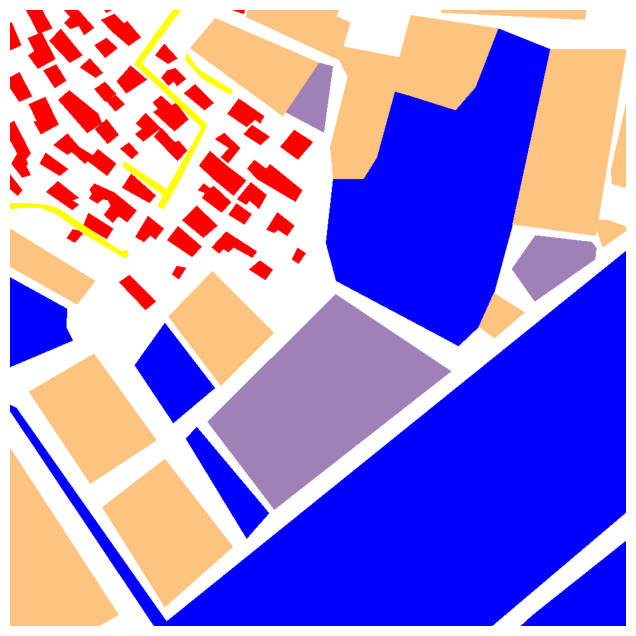

In [25]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

# Colors (same as you provided)
COLORS = {
    "Background": (255, 255, 255),
    "Building": (255, 0, 0),
    "Road": (255, 255, 0),
    "Water": (0, 0, 255),
    "Barren": (159, 129, 183),
    "Forest": (0, 255, 0),
    "Agricultural": (255, 195, 128),
}

def loveda_mask_to_rgb(mask_2d: np.ndarray) -> np.ndarray:
    """
    Works for:
    - Official LoveDA labels: 0=NoData(ignore), 1..7=classes
    - Reduced labels (common): 0..6=classes, 255=ignore
    """
    if mask_2d.ndim != 2:
        raise ValueError(f"Expected (H,W) mask, got shape {mask_2d.shape}")

    # LUT for 0..255
    lut = np.zeros((256, 3), dtype=np.uint8)

    # Make NO-DATA / IGNORE white
    lut[0]   = (255, 255, 255)   # official no-data
    lut[255] = (255, 255, 255)   # ignore_index variant

    u = np.unique(mask_2d)

    if u.max() <= 7:
        # Official LoveDA: background=1, building=2, ..., agriculture=7
        lut[1] = COLORS["Background"]
        lut[2] = COLORS["Building"]
        lut[3] = COLORS["Road"]
        lut[4] = COLORS["Water"]
        lut[5] = COLORS["Barren"]
        lut[6] = COLORS["Forest"]
        lut[7] = COLORS["Agricultural"]
    else:
        # Reduced labels: background=0, building=1, ..., agriculture=6; ignore often 255
        lut[0] = COLORS["Background"]
        lut[1] = COLORS["Building"]
        lut[2] = COLORS["Road"]
        lut[3] = COLORS["Water"]
        lut[4] = COLORS["Barren"]
        lut[5] = COLORS["Forest"]
        lut[6] = COLORS["Agricultural"]

    # Colorize
    return lut[mask_2d.astype(np.uint8)]

# Load mask safely as single-channel
mask_pil = Image.open(MASK1)
mask = np.array(mask_pil)
if mask.ndim == 3:
    # if someone saved it as RGB by mistake, take one channel or convert
    mask = np.array(mask_pil.convert("L"))

rgb = loveda_mask_to_rgb(mask)

plt.figure(figsize=(8, 8))
plt.imshow(rgb)
plt.axis("off")
# plt.title("LOVEDA Mask (RGB)")
plt.show()


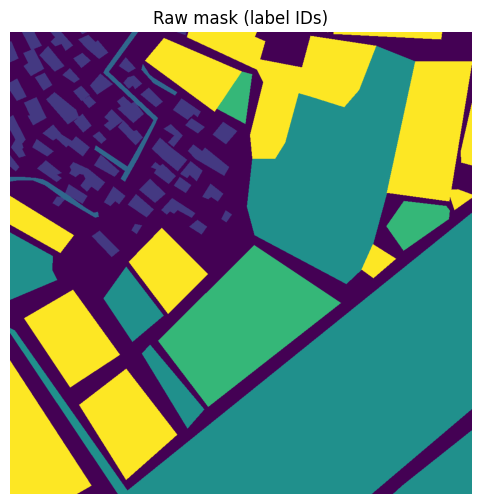

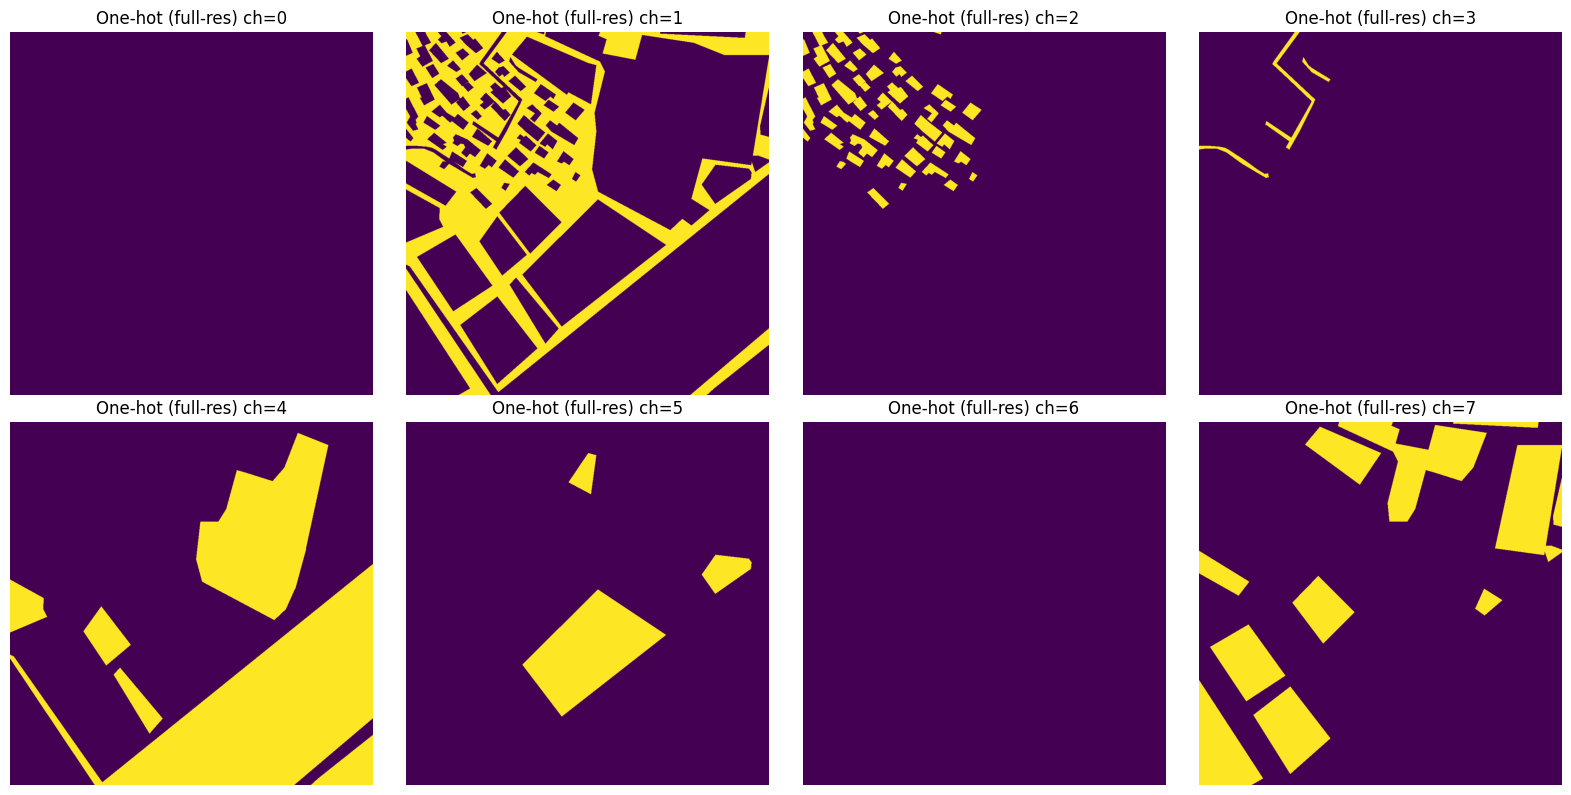

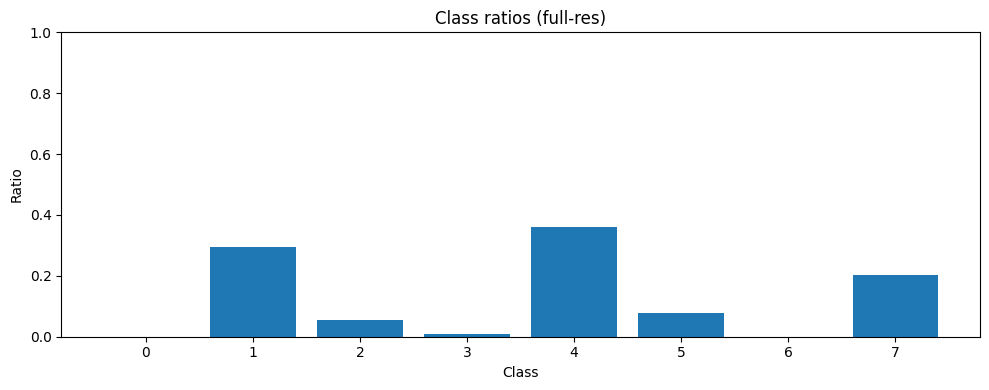

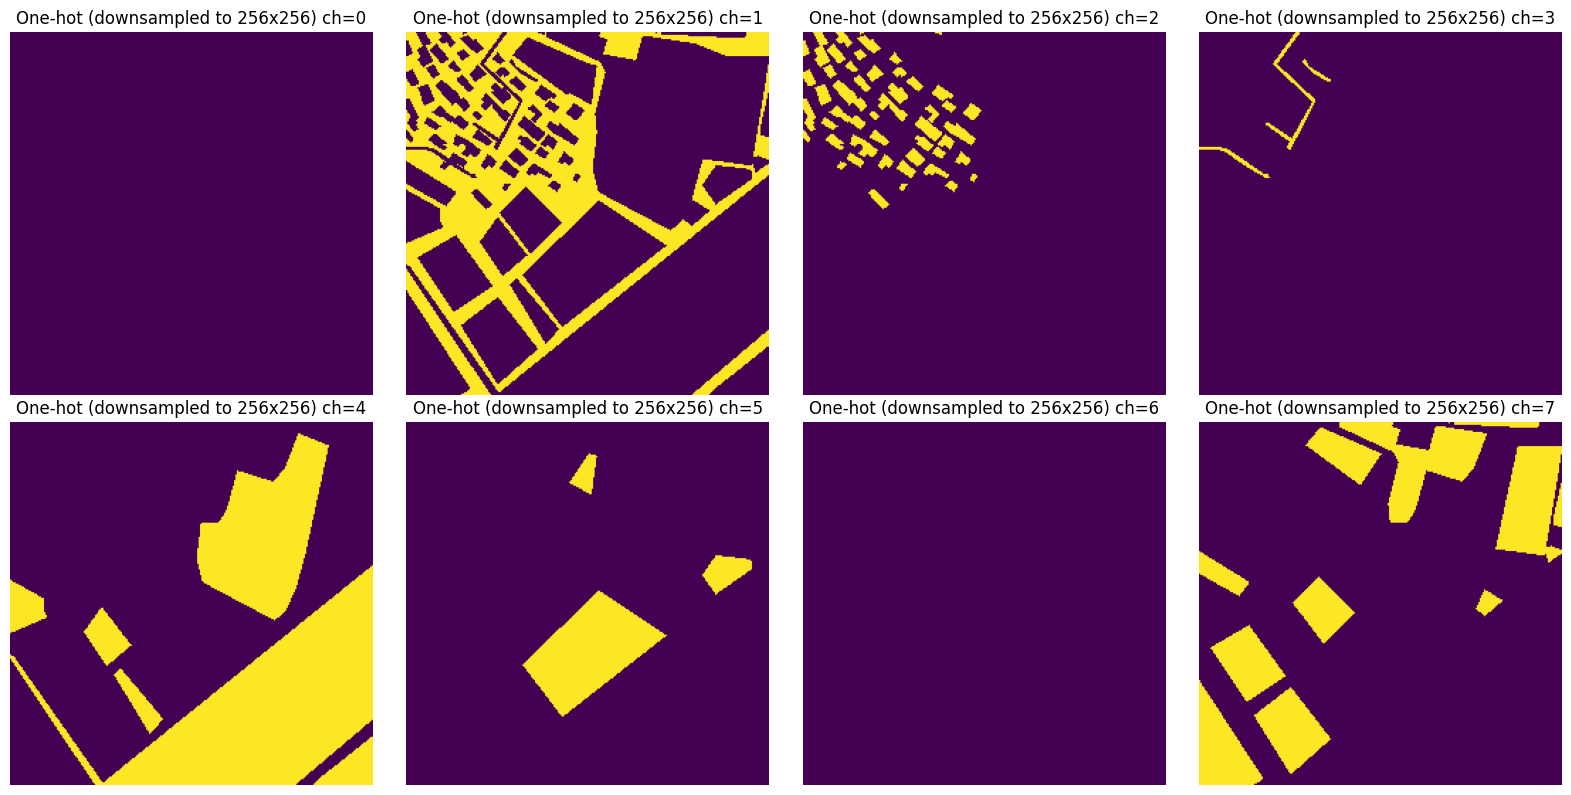

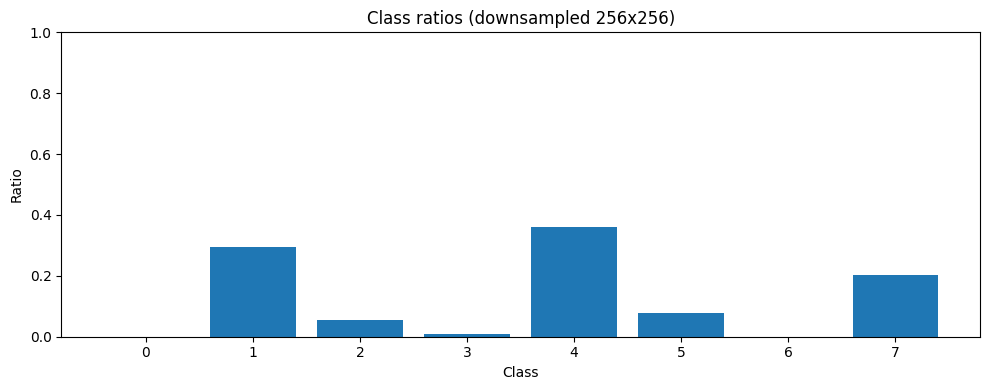

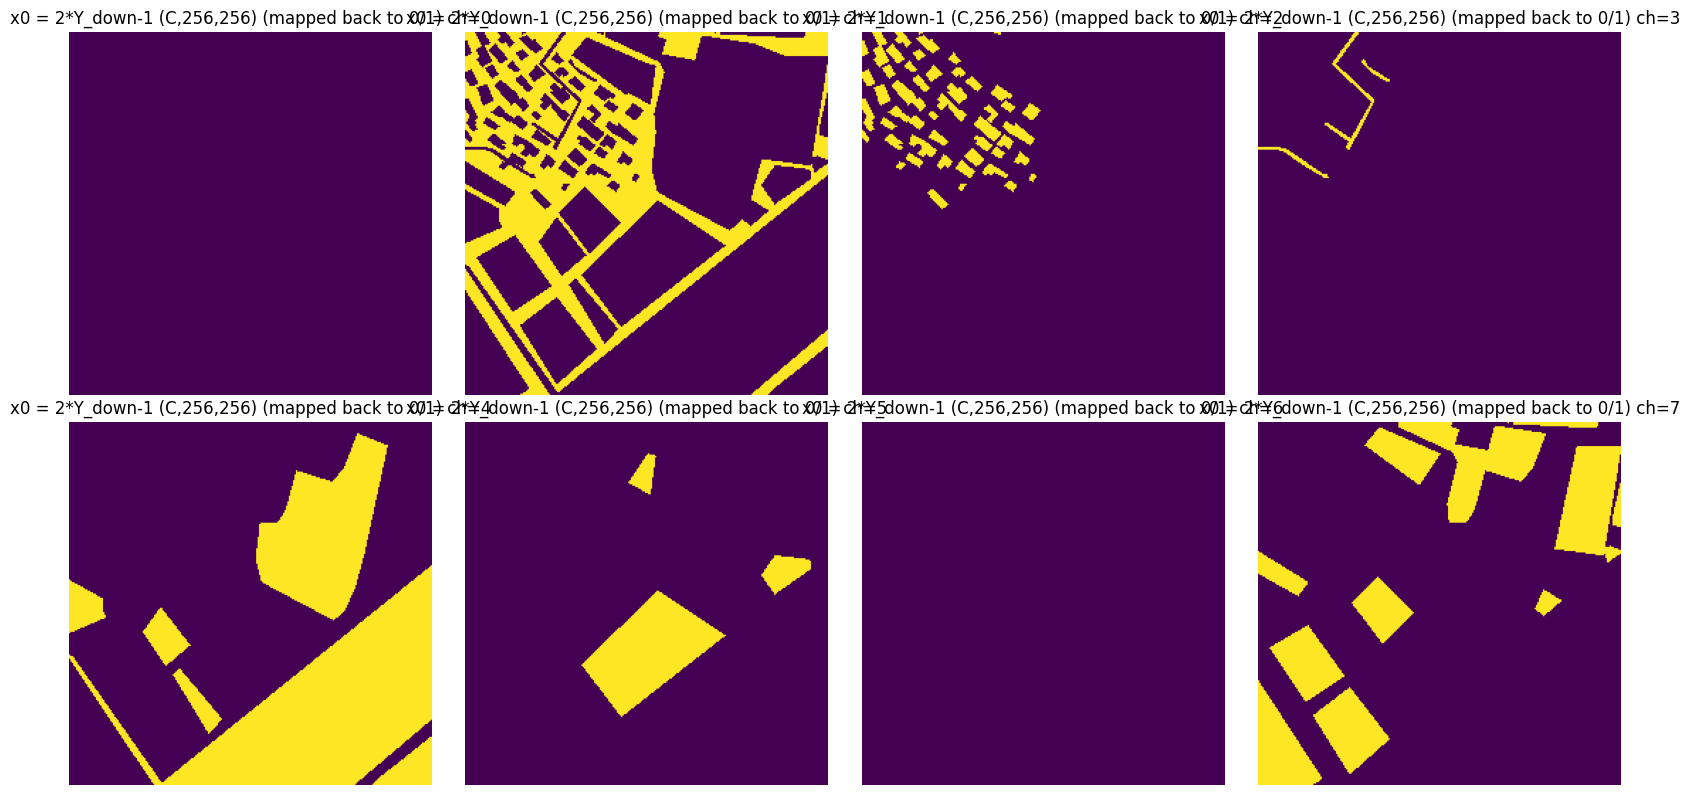

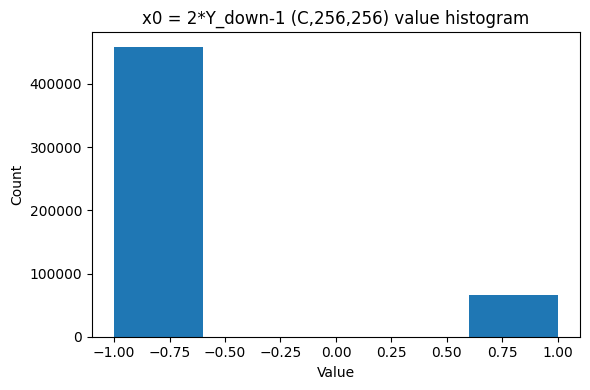

In [28]:
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

# ---------------------------
# Utilities from before
# ---------------------------
def mask_to_onehot(mask_2d: np.ndarray, num_classes: int, ignore_index: int = 255) -> torch.Tensor:
    if mask_2d.ndim != 2:
        raise ValueError(f"Expected (H,W) mask, got {mask_2d.shape}")

    m = torch.from_numpy(mask_2d).long()  # (H,W)
    valid = (m != ignore_index)

    m_clamped = m.clone()
    m_clamped[~valid] = 0

    oh = F.one_hot(m_clamped, num_classes=num_classes).permute(2, 0, 1).float()  # (C,H,W)
    oh[:, ~valid] = 0.0
    return oh

def downsample_onehot_nearest(onehot: torch.Tensor, layout_size: int) -> torch.Tensor:
    x = onehot.unsqueeze(0)  # (1,C,H,W)
    x_down = F.interpolate(x, size=(layout_size, layout_size), mode="nearest")
    return x_down.squeeze(0)

def onehot_class_ratios(onehot: torch.Tensor, eps: float = 1e-8) -> torch.Tensor:
    counts = onehot.sum(dim=(1, 2))
    total = counts.sum().clamp_min(eps)
    return counts / total

def scale_to_diffusion_space(onehot_down: torch.Tensor) -> torch.Tensor:
    return 2.0 * onehot_down - 1.0

# ---------------------------
# Visualization helpers
# ---------------------------
def plot_onehot_channels(onehot: torch.Tensor, title_prefix: str = "One-hot", max_cols: int = 4):
    """
    onehot: (C,H,W)
    Shows each channel as a grayscale image (0/1).
    """
    if onehot.ndim != 3:
        raise ValueError(f"Expected (C,H,W), got {onehot.shape}")

    C, H, W = onehot.shape
    ncols = min(max_cols, C)
    nrows = (C + ncols - 1) // ncols

    fig, axes = plt.subplots(nrows, ncols, figsize=(4*ncols, 4*nrows))
    axes = np.array(axes).reshape(-1)

    for c in range(C):
        ax = axes[c]
        ax.imshow(onehot[c].cpu().numpy(), vmin=0, vmax=1)
        ax.set_title(f"{title_prefix} ch={c}")
        ax.axis("off")

    for k in range(C, len(axes)):
        axes[k].axis("off")

    plt.tight_layout()
    plt.show()

def plot_ratios_bar(ratios: torch.Tensor, class_names=None, title="Class ratios"):
    """
    ratios: (C,)
    """
    r = ratios.detach().cpu().numpy()
    x = np.arange(len(r))

    plt.figure(figsize=(10, 4))
    plt.bar(x, r)
    plt.ylim(0, 1)
    plt.title(title)
    plt.xlabel("Class")
    plt.ylabel("Ratio")

    if class_names is not None and len(class_names) == len(r):
        plt.xticks(x, class_names, rotation=45, ha="right")
    else:
        plt.xticks(x, [str(i) for i in x])

    plt.tight_layout()
    plt.show()

def plot_x0_stats(x0: torch.Tensor, title="x0 in diffusion space"):
    """
    x0: (C,H,W) in {-1, +1}
    Visualize:
      (a) first few channels
      (b) histogram of values
    """
    plot_onehot_channels((x0 + 1) / 2, title_prefix=title + " (mapped back to 0/1)")

    vals = x0.detach().cpu().numpy().ravel()
    plt.figure(figsize=(6, 4))
    plt.hist(vals, bins=5)
    plt.title(title + " value histogram")
    plt.xlabel("Value")
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()

# ---------------------------
# End-to-end example
# ---------------------------
def visualize_pipeline(mask_2d: np.ndarray, layout_size: int, num_classes: int, ignore_index: int = 255, class_names=None):
    # 1) one-hot
    onehot = mask_to_onehot(mask_2d, num_classes=num_classes, ignore_index=ignore_index)
    ratios_full = onehot_class_ratios(onehot)

    # 2) downsample
    onehot_down = downsample_onehot_nearest(onehot, layout_size=layout_size)
    ratios_down = onehot_class_ratios(onehot_down)

    # 3) diffusion scaling
    x0 = scale_to_diffusion_space(onehot_down)

    # ---- Visualizations ----
    plt.figure(figsize=(6, 6))
    plt.imshow(mask_2d)
    plt.title("Raw mask (label IDs)")
    plt.axis("off")
    plt.show()

    plot_onehot_channels(onehot, title_prefix="One-hot (full-res)")

    plot_ratios_bar(ratios_full, class_names=class_names, title="Class ratios (full-res)")

    plot_onehot_channels(onehot_down, title_prefix=f"One-hot (downsampled to {layout_size}x{layout_size})")

    plot_ratios_bar(ratios_down, class_names=class_names, title=f"Class ratios (downsampled {layout_size}x{layout_size})")

    plot_x0_stats(x0, title=f"x0 = 2*Y_down-1 (C,{layout_size},{layout_size})")

    return onehot, onehot_down, x0, ratios_full, ratios_down

# ---------------------------
# Usage
# ---------------------------
mask_2d = np.array(Image.open(MASK1).convert("L"))  # ensure (H,W)
class_names = list(LABEL_MAP_LOVEDA.keys())
onehot, onehot_down, x0, ratios_full, ratios_down = visualize_pipeline(
    mask_2d=mask_2d,
    layout_size=256,
    num_classes=8,
    ignore_index=255,
    class_names=class_names
)

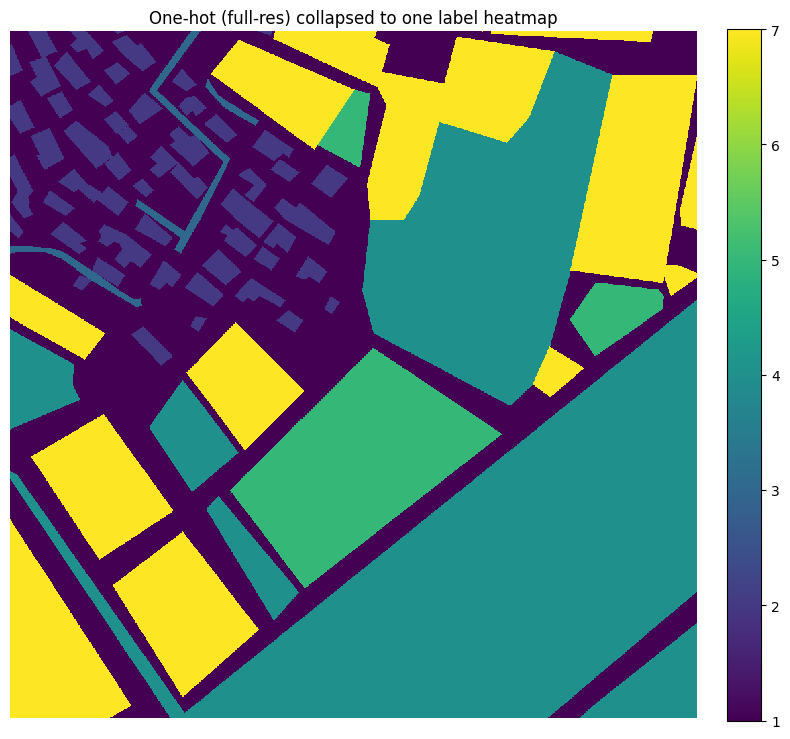

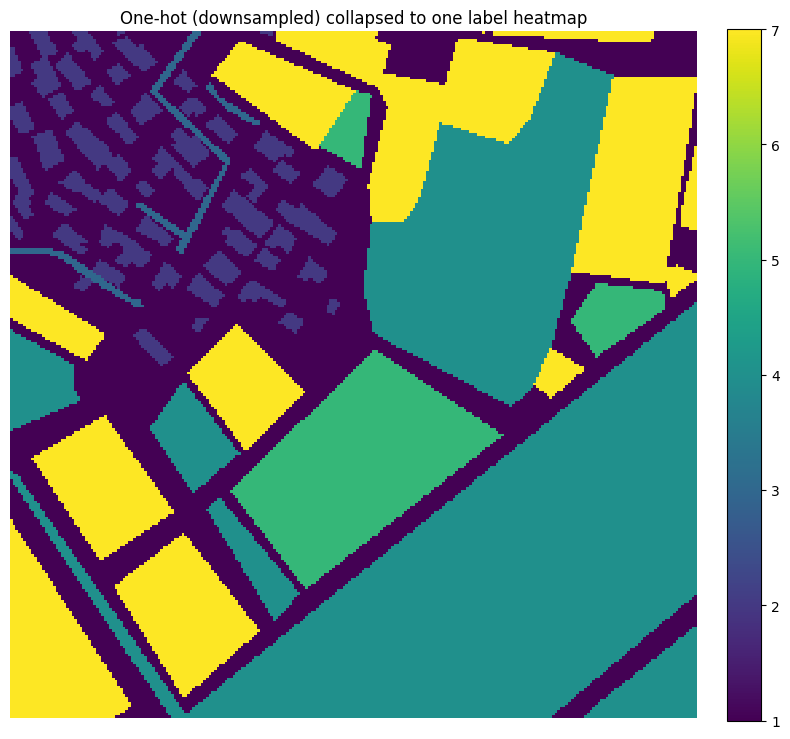

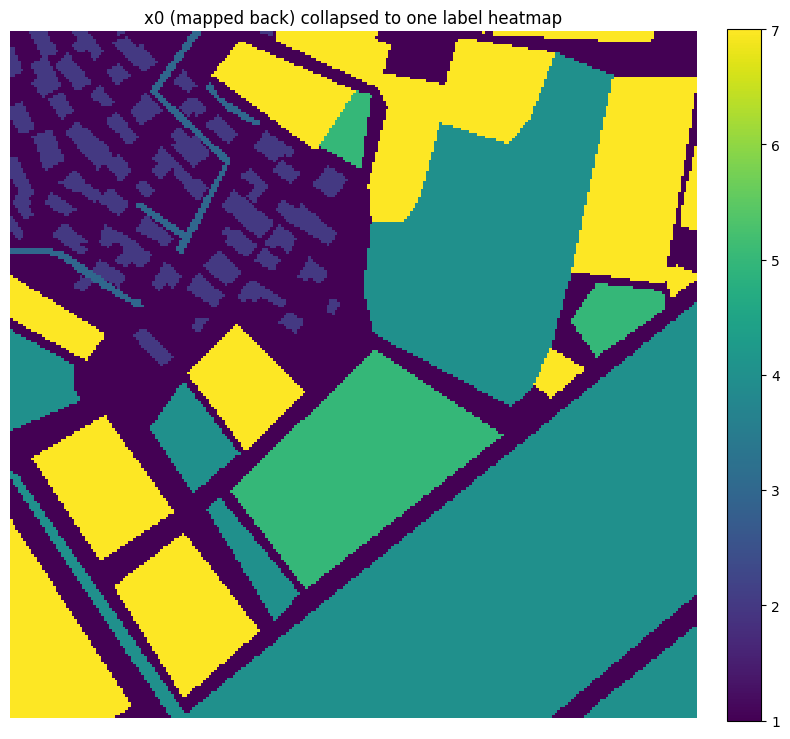

In [30]:
import numpy as np
import torch
import matplotlib.pyplot as plt

def onehot_to_labelmap(onehot: torch.Tensor, ignore_all_zero: bool = True, ignore_value: int = -1) -> np.ndarray:
    """
    onehot: (C,H,W) in {0,1} (or [0,1])
    Returns a single (H,W) label map via argmax.

    If ignore_all_zero=True, pixels where all channels are 0 are set to ignore_value.
    """
    if onehot.ndim != 3:
        raise ValueError(f"Expected (C,H,W), got {onehot.shape}")

    # argmax over channels
    labels = torch.argmax(onehot, dim=0)  # (H,W)

    if ignore_all_zero:
        valid = (onehot.sum(dim=0) > 0)    # (H,W)
        labels = labels.clone()
        labels[~valid] = ignore_value

    return labels.detach().cpu().numpy()

def plot_label_heatmap(label_map: np.ndarray, title: str = "Segmentation heatmap"):
    """
    label_map: (H,W) int, can contain -1 for ignore.
    Shows ONE image (heatmap) where value indicates class index.
    """
    plt.figure(figsize=(8, 8))
    im = plt.imshow(label_map, interpolation="nearest")
    plt.title(title)
    plt.axis("off")
    plt.colorbar(im, fraction=0.046, pad=0.04)  # shows class index scale
    plt.tight_layout()
    plt.show()

# ---- Example: visualize ALL channels collapsed into ONE heatmap ----
# (A) Full-res onehot -> one heatmap
label_full = onehot_to_labelmap(onehot, ignore_all_zero=True, ignore_value=-1)
plot_label_heatmap(label_full, title="One-hot (full-res) collapsed to one label heatmap")

# (B) Downsampled onehot -> one heatmap
label_down = onehot_to_labelmap(onehot_down, ignore_all_zero=True, ignore_value=-1)
plot_label_heatmap(label_down, title="One-hot (downsampled) collapsed to one label heatmap")

# (C) x0 -> map back to {0,1} then heatmap
label_x0 = onehot_to_labelmap((x0 + 1) / 2, ignore_all_zero=True, ignore_value=-1)
plot_label_heatmap(label_x0, title="x0 (mapped back) collapsed to one label heatmap")
